In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# TO GET THE CSV SCROLL DOWN AND RUN CELL

In [267]:
tran=pd.read_csv('transaction.csv',parse_dates=['DATE'])
price=pd.read_csv('pricing.csv',parse_dates=['DATE'])
act=pd.read_csv('activity.csv',parse_dates=['DATE'])
mark=pd.read_csv('marketing.csv',parse_dates=['DATE'])

In [268]:
tran.head(2)

,DATE,USERID,PRICE,UNITS,TOTAL
0,2015-04-03,1052,4.0,1,4.0
1,2015-04-03,1059,4.0,2,8.0


In [269]:
######################## Features Creation Part of my exploration  ############################################################

In [270]:
act=pd.get_dummies(act, columns=['ACTIVITY'])

In [271]:
from math import ceil
def week_of_month(dt):
    if (100*dt.year + dt.month)<201607:
        first_day = dt.replace(day=1)
        dom = dt.day
        adjusted_dom = dom + first_day.weekday()
        return int(ceil(adjusted_dom/7.0))
    else:
        return 5

In [272]:
act['week_of_month']=act['DATE'].apply(week_of_month)
act['day_of_month']=act['DATE'].apply(lambda x:x.day if (100*x.year + x.month)<201607 else 30)
tran['week_of_month']=tran['DATE'].apply(week_of_month)
tran['day_of_month']=tran['DATE'].apply(lambda x:x.day if (100*x.year + x.month)<201607 else 30)
act['month_of_yr']=act['DATE'].map(lambda DATE: 100*DATE.year + DATE.month if((100*DATE.year + DATE.month)<201607) else 201606)
tran['month_of_yr']=tran['DATE'].map(lambda DATE: 100*DATE.year + DATE.month if((100*DATE.year + DATE.month)<201607) else 201606)

In [273]:
logincount_wom=act.groupby(['month_of_yr','week_of_month','USERID'])['ACTIVITY_logged in'].sum().reset_index()
logincount_m=act.groupby(['month_of_yr','USERID'])['ACTIVITY_logged in'].sum().reset_index()
logincount_m=logincount_m.rename(columns = {'ACTIVITY_logged in':'monthly_lc'})
logincount_wom=logincount_wom.rename(columns = {'ACTIVITY_logged in':'weekly_lc'})

In [274]:
act = pd.merge(act,logincount_wom, on=['USERID','month_of_yr','week_of_month'],how='left')
act = pd.merge(act,logincount_m, on=['USERID','month_of_yr'],how='left')
revenue_upm=tran.groupby(['USERID','month_of_yr'])['TOTAL'].sum().reset_index()
revenue_upw=tran.groupby(['USERID','month_of_yr','week_of_month'])['TOTAL'].sum().reset_index()
monthly_avg=tran.groupby(['USERID','month_of_yr'])['TOTAL'].mean().reset_index()
weekly_avg=tran.groupby(['USERID','month_of_yr','week_of_month'])['TOTAL'].mean().reset_index()
revenue_upm=revenue_upm.rename(columns = {'TOTAL':'revenue_upm'})
revenue_upw=revenue_upw.rename(columns = {'TOTAL':'revenue_upw'})
monthly_avg=monthly_avg.rename(columns = {'TOTAL':'monthly_avg'})
weekly_avg=weekly_avg.rename(columns = {'TOTAL':'weekly_avg'})

In [275]:
data = pd.merge(act,revenue_upm, on=['USERID','month_of_yr'],how='left')
data = pd.merge(data,revenue_upw, on=['USERID','month_of_yr','week_of_month'],how='left')
data = pd.merge(data,monthly_avg, on=['USERID','month_of_yr'],how='left')
data = pd.merge(data,weekly_avg, on=['USERID','month_of_yr','week_of_month'],how='left')
data=data.fillna(0)

In [276]:
data.head()

,DATE,USERID,ACTIVITY_created account,ACTIVITY_logged in,week_of_month,day_of_month,month_of_yr,weekly_lc,monthly_lc,revenue_upm,revenue_upw,monthly_avg,weekly_avg
0,2015-04-03,1000,1,0,1,3,201504,3,24,32.0,0.0,4.000000,0.0
1,2015-04-03,1000,0,1,1,3,201504,3,24,32.0,0.0,4.000000,0.0
2,2015-04-03,1001,1,0,1,3,201504,2,18,22.0,0.0,7.333333,0.0
3,2015-04-03,1001,0,1,1,3,201504,2,18,22.0,0.0,7.333333,0.0
4,2015-04-03,1002,1,0,1,3,201504,2,20,24.0,0.0,12.000000,0.0


In [277]:
log_info=data[data['ACTIVITY_created account']==1].reset_index()
log_info=log_info[['USERID','DATE']]
log_info=log_info.rename(columns = {'DATE':'ac_created_on'})

In [278]:
log_info['week_of_create']=log_info['ac_created_on'].apply(week_of_month)
log_info['day_of_create']=log_info['ac_created_on'].apply(lambda x:x.day if (100*x.year + x.month)<201607 else 30)
log_info['month_of_create']=log_info['ac_created_on'].map(lambda ac_created_on: 100*ac_created_on.year + ac_created_on.month)
log_info=log_info.drop('ac_created_on',1)

In [279]:
newdata=data.drop(['DATE','ACTIVITY_created account','ACTIVITY_logged in','week_of_month','day_of_month'],1)
newdata=newdata.drop_duplicates(keep="first", inplace=False).reset_index()
newdata=newdata.drop('index',1)

In [280]:
log_freq_sum=newdata.groupby(['USERID','month_of_yr'])['weekly_lc','monthly_lc','revenue_upm','revenue_upw'].sum().reset_index()
log_freq_avg=newdata.groupby(['USERID','month_of_yr'])['weekly_lc','monthly_lc','revenue_upm','revenue_upw'].mean().reset_index()

In [281]:
log_freq_sum=log_freq_sum.rename(columns = {'weekly_lc':'sum_weekly_lc','monthly_lc':'sum_monthly_lc','revenue_upm':'t_revenue_upm','revenue_upw':'t_revenue_upw'})
log_freq_avg=log_freq_avg.rename(columns = {'weekly_lc':'avg_weekly_lc','monthly_lc':'avg_monthly_lc','revenue_upm':'avg_revenue_upm','revenue_upw':'avg_revenue_upw'})

In [282]:
log_freq_info = pd.merge(log_freq_sum,log_freq_avg, on=['USERID','month_of_yr'],how='left')

In [283]:
log_freq_info.head(2)

,USERID,month_of_yr,sum_weekly_lc,sum_monthly_lc,t_revenue_upm,t_revenue_upw,avg_weekly_lc,avg_monthly_lc,avg_revenue_upm,avg_revenue_upw
0,1000,201504,21,96,128.0,32.0,5.25,24.0,32.0,8.00
1,1000,201505,20,80,108.0,27.0,5.00,20.0,27.0,6.75


In [284]:
log_info.head(2)

,USERID,week_of_create,day_of_create,month_of_create
0,1000,1,3,201504
1,1001,1,3,201504


In [285]:
log_data=pd.merge(log_freq_info,log_info, on=['USERID'],how='left')

In [286]:
# data=data.drop(['DATE','ACTIVITY_created account','ACTIVITY_logged in'],1)
# data=data.drop_duplicates(keep="first", inplace=False).reset_index()

In [287]:
# data=data.drop('index',1)

In [288]:
# def usertype(ym,cm):
#     if ym==cm:
#         return 'new'
#     else:
#         return 'old'   

In [289]:
# new_user=data[data['ACTIVITY_created account']==1].reset_index()
# new_user=new_user[['USERID','month_of_yr']]
# new_user=new_user.rename(columns = {'month_of_yr':'ac_creat_month'})
# data = pd.merge(data,new_user, on=['USERID'],how='left')

In [290]:
# data['user_type']=data.apply(lambda row : usertype(row['month_of_yr'],row['ac_creat_month']), axis = 1)

In [291]:
# df=data.drop_duplicates(keep="first", inplace=False).reset_index()
# df=df.drop('index',1)

In [292]:
result=pd.read_csv('problem-two-new-users.csv',header=None)
result=result.rename(columns = {0:'USERID'})
test=pd.merge(result,log_data, on=['USERID'],how='left')

In [293]:
######################################################## Creating target variable###############################################

In [294]:
log_data.head()

,USERID,month_of_yr,sum_weekly_lc,sum_monthly_lc,t_revenue_upm,t_revenue_upw,avg_weekly_lc,avg_monthly_lc,avg_revenue_upm,avg_revenue_upw,week_of_create,day_of_create,month_of_create
0,1000,201504,21,96,128.0,32.0,5.25,24.0,32.0,8.00,1,3,201504
1,1000,201505,20,80,108.0,27.0,5.00,20.0,27.0,6.75,1,3,201504
2,1001,201504,13,72,88.0,18.0,3.25,18.0,22.0,4.50,1,3,201504
3,1001,201505,15,76,92.0,19.0,3.75,19.0,23.0,4.75,1,3,201504
4,1001,201506,23,115,170.0,34.0,4.60,23.0,34.0,6.80,1,3,201504


In [295]:
df=log_data

In [296]:
train=pd.DataFrame()
for ym in list(set(df['month_of_yr'])):
    if ym+4<=201512:
        tym=ym+4
        temp_data=df[df['month_of_yr']<tym]
        temp_x1=temp_data[(temp_data['month_of_yr']==ym) & (temp_data['month_of_create']==ym)]
        temp_y1=temp_data[(temp_data['month_of_yr']>ym) & (temp_data['month_of_create']==ym)].groupby(['USERID'])['t_revenue_upm'].sum().reset_index()
        temp_y1 =temp_y1.rename(columns = {'t_revenue_upm':'high_value'})
        train_data=pd.merge(temp_x1, temp_y1, on='USERID', how='left')
#         train_data['high_value'] = train_data.apply(lambda row : high_value(row['high_value']), axis = 1)
        if len(train)==0:
            train=train_data
        else:
            train=pd.concat([train,train_data])

    if ym+4>201512 and ym<=201512:
        tym=201600
        temp_data=df[df['month_of_yr']<tym+4-(201512-ym)]
        temp_x1=temp_data[(temp_data['month_of_yr']==ym) & (temp_data['month_of_create']==ym)]
        temp_y1=temp_data[(temp_data['month_of_yr']>ym) & (temp_data['month_of_create']==ym)].groupby(['USERID'])['t_revenue_upm'].sum().reset_index()
        temp_y1 =temp_y1.rename(columns = {'t_revenue_upm':'high_value'})
        train_data=pd.merge(temp_x1, temp_y1, on='USERID', how='left')
#         train_data['high_value'] = train_data.apply(lambda row : high_value(row['high_value']), axis = 1)
        if len(train)==0:
            train=train_data
        else:
            train=pd.concat([train,train_data])
    
    if  ym>201512 and ym<201603:
        temp_data=df[df['month_of_yr']<ym+4]
        temp_x1=temp_data[(temp_data['month_of_yr']==ym) & (temp_data['month_of_create']==ym)]
        temp_y1=temp_data[(temp_data['month_of_yr']>ym) & (temp_data['month_of_create']==ym)].groupby(['USERID'])['t_revenue_upm'].sum().reset_index()
        temp_y1 =temp_y1.rename(columns = {'t_revenue_upm':'high_value'})
        train_data=pd.merge(temp_x1, temp_y1, on='USERID', how='left')
#         train_data['high_value'] = train_data.apply(lambda row : high_value(row['high_value']), axis = 1)
        if len(train)==0:
            train=train_data
        else:
            train=pd.concat([train,train_data])
    if  ym>201512 and ym==201603:
        temp_data=df[df['month_of_yr']>=ym]
        temp_x1=temp_data[(temp_data['month_of_yr']==ym) & (temp_data['month_of_create']==ym)]
        temp_y1=temp_data[(temp_data['month_of_yr']>ym) & (temp_data['month_of_create']==ym)].groupby(['USERID'])['t_revenue_upm'].sum().reset_index()
        temp_y1 =temp_y1.rename(columns = {'t_revenue_upm':'high_value'})
        train_data=pd.merge(temp_x1, temp_y1, on='USERID', how='left')
#         train_data['high_value'] = train_data.apply(lambda row : high_value(row['high_value']), axis = 1)
        if len(train)==0:
            train=train_data
        else:
            train=pd.concat([train,train_data])

In [297]:
train=train.fillna(0)
train.isna().sum()

USERID             0
month_of_yr        0
sum_weekly_lc      0
sum_monthly_lc     0
t_revenue_upm      0
t_revenue_upw      0
avg_weekly_lc      0
avg_monthly_lc     0
avg_revenue_upm    0
avg_revenue_upw    0
week_of_create     0
day_of_create      0
month_of_create    0
high_value         0
dtype: int64

In [298]:
def high_value(x):
    if x>=100:
        return 1
    else:
        return 0

In [299]:
train['high_value'] = train.apply(lambda row : high_value(row['high_value']), axis = 1)

In [300]:
train=train.reset_index()
train=train.drop('index',1)
train.head(2)

,USERID,month_of_yr,sum_weekly_lc,sum_monthly_lc,t_revenue_upm,t_revenue_upw,avg_weekly_lc,avg_monthly_lc,avg_revenue_upm,avg_revenue_upw,week_of_create,day_of_create,month_of_create,high_value
0,1000,201504,21,96,128.0,32.0,5.25,24.0,32.0,8.0,1,3,201504,1
1,1001,201504,13,72,88.0,18.0,3.25,18.0,22.0,4.5,1,3,201504,1


In [301]:
x=train.drop(['high_value','USERID'],1)
y=train['high_value']

In [302]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.33, random_state=42)
model = XGBClassifier(learning_rate=0.8,n_estimators=300)
model.fit(X_train, y_train)
# make predictions for test data
y_predxg = model.predict(X_test)
predictions = [round(value) for value in y_predxg]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 65.44%


In [303]:
from sklearn.ensemble import RandomForestClassifier
#Create a Gaussian Classifier
clf=RandomForestClassifier(max_depth=2,n_estimators=300)
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)
y_predrf=clf.predict(X_test)
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_predrf))

Accuracy: 0.6220785479077986


In [304]:
# train=train.drop_duplicates(keep="first", inplace=False).reset_index()
# train=train.drop(['index','DATE','USERID','ACTIVITY_created account','ACTIVITY_logged in'],1)
result=pd.read_csv('problem-two-new-users.csv',header=None)
result=result.rename(columns = {0:'USERID'})
test=pd.merge(result,df, on=['USERID'],how='left')

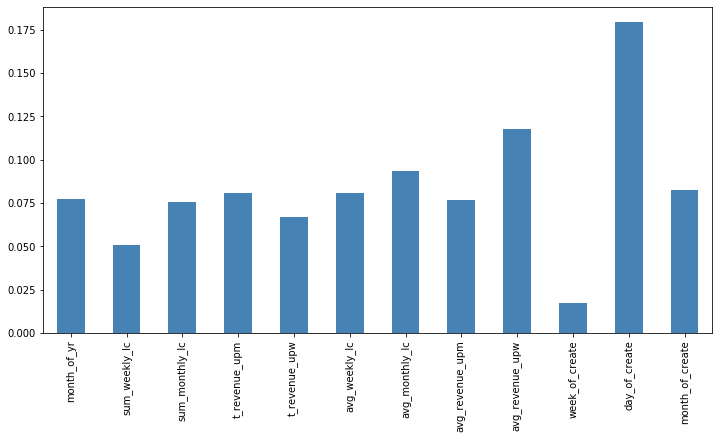

In [305]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(x, y)

pd.Series(clf.feature_importances_, index=x.columns).plot.bar(color='steelblue', figsize=(12, 6))

In [306]:
from sklearn.feature_selection import SelectFromModel

clf = DecisionTreeClassifier()
trans = SelectFromModel(clf, threshold='median')
x_trans = trans.fit_transform(x, y)

In [307]:
print("We started with {0} features but retained only {1} of them!".format(x.shape[1] - 1,x_trans.shape[1]))

We started with 11 features but retained only 6 of them!


In [308]:
columns_retained_FromMode = x.columns[trans.get_support()].values

In [309]:
columns_retained_FromMode

array(['t_revenue_upm', 'avg_weekly_lc', 'avg_monthly_lc',
       'avg_revenue_upw', 'day_of_create', 'month_of_create'],
      dtype=object)

In [310]:
from sklearn.feature_selection import RFE
clf = DecisionTreeClassifier()
trans = RFE(clf, n_features_to_select=6)
x_trans = trans.fit_transform(x,y)
columns_retained_RFE = x.columns[trans.get_support()].values
columns_retained_RFE

array(['month_of_yr', 't_revenue_upm', 'avg_weekly_lc', 'avg_monthly_lc',
       'avg_revenue_upw', 'day_of_create'], dtype=object)

In [311]:
from sklearn.feature_selection import RFECV
clf = DecisionTreeClassifier()
trans = RFECV(clf,min_features_to_select=2)
x_trans = trans.fit_transform(x,y)
columns_retained_RFECV =x.columns[trans.get_support()].values
columns_retained_RFECV

array(['avg_monthly_lc', 'avg_revenue_upw'], dtype=object)

In [312]:
x.columns

Index(['month_of_yr', 'sum_weekly_lc', 'sum_monthly_lc', 't_revenue_upm',
       't_revenue_upw', 'avg_weekly_lc', 'avg_monthly_lc', 'avg_revenue_upm',
       'avg_revenue_upw', 'week_of_create', 'day_of_create',
       'month_of_create'],
      dtype='object')

In [313]:
colum=['t_revenue_upm', 'avg_weekly_lc', 'avg_monthly_lc','avg_revenue_upw', 'day_of_create']

In [314]:
xtemp=x[colum]
ytemp=train['high_value']
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(xtemp,ytemp, test_size=0.33, random_state=42)
model = XGBClassifier(learning_rate=0.8,n_estimators=300)
model.fit(X_train, y_train)
# make predictions for test data
y_predxg = model.predict(X_test)
predictions = [round(value) for value in y_predxg]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 65.38%


In [315]:
xtemp=x[list(columns_retained_RFE)]
ytemp=train['high_value']
X_train, X_test, y_train, y_test = train_test_split(xtemp,ytemp, test_size=0.33, random_state=42)
from sklearn.ensemble import RandomForestClassifier
#Create a Gaussian Classifier
clf=RandomForestClassifier(max_depth=2,n_estimators=300)
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)
y_predrf=clf.predict(X_test)
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_predrf))

Accuracy: 0.6220785479077986


In [316]:
testtemp=test[colum]
y_pred_test=model.predict(testtemp)

In [317]:
test['high_value']=y_pred_test

In [318]:
x.head(2)

,month_of_yr,sum_weekly_lc,sum_monthly_lc,t_revenue_upm,t_revenue_upw,avg_weekly_lc,avg_monthly_lc,avg_revenue_upm,avg_revenue_upw,week_of_create,day_of_create,month_of_create
0,201504,21,96,128.0,32.0,5.25,24.0,32.0,8.0,1,3,201504
1,201504,13,72,88.0,18.0,3.25,18.0,22.0,4.5,1,3,201504


In [319]:
test.head(2)

,USERID,month_of_yr,sum_weekly_lc,sum_monthly_lc,t_revenue_upm,t_revenue_upw,avg_weekly_lc,avg_monthly_lc,avg_revenue_upm,avg_revenue_upw,week_of_create,day_of_create,month_of_create,high_value
0,88430,201606,21,105,160.0,32.0,4.2,21.0,32.0,6.4,1,5,201606,1
1,88431,201606,18,96,24.0,6.0,4.5,24.0,6.0,1.5,1,5,201606,1


In [320]:
test=test.drop('USERID',1)

In [321]:
# test=test.drop_duplicates(keep="first", inplace=False).reset_index()
# y_pred_test=clf.predict(test)

#  Run below cells to generate csv 

In [322]:
######################################################## PS-2 Solution #########################################################

In [323]:
tran=pd.read_csv('transaction.csv',parse_dates=['DATE'])
price=pd.read_csv('pricing.csv',parse_dates=['DATE'])
act=pd.read_csv('activity.csv',parse_dates=['DATE'])
mark=pd.read_csv('marketing.csv',parse_dates=['DATE'])

In [324]:
account_created=act[act['ACTIVITY']=='created account']

In [325]:
account_login=act[act['ACTIVITY']=='logged in']

In [326]:
account_login['YearMonth'] = account_login['DATE'].map(lambda DATE: 100*DATE.year + DATE.month)
# account_created['YearMonth'] = account_created['DATE'].map(lambda DATE: 100*DATE.year + DATE.month)

C:\Users\AJAY\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [327]:
user_new= pd.DataFrame()
user_new = account_created.drop(['ACTIVITY'], axis = 1)
user_new = user_new.rename(columns = {'DATE':'CREATED_AT'})

In [328]:
# t_data = pd.merge(tran, user_new, on='USERID')
t_data = pd.merge(user_new,tran, on='USERID')

In [329]:
t_data['createdmonth'] = t_data['CREATED_AT'].map(lambda DATE: (100*DATE.year + DATE.month))
t_data['YearMonth'] = t_data['DATE'].map(lambda DATE:(100*DATE.year + DATE.month))

In [330]:
t_data=t_data.drop('CREATED_AT',1)

In [331]:
def usertype(ym,cm):
    if str(ym)=='nan' and str(cm)!='nan':
        return 'new'
    if round(ym)==round(cm):
        return 'new'
    else:
        return 'old'
    

In [332]:
t_data['type'] = t_data.apply(lambda row : usertype(row['YearMonth'], 
                     row['createdmonth']), axis = 1)

In [333]:
login_count=account_login.groupby(['YearMonth','USERID']).count().reset_index()

In [334]:
login_count=login_count.drop('DATE',1)
login_count =login_count.rename(columns = {'YearMonth':'month_of_activity'})
# login_count=login_count.groupby(['USERID'])['ACTIVITY'].sum().reset_index()

In [335]:
# t_data = pd.merge(t_data, login_count, on=['USERID','YearMonth'])

In [336]:
t_data = pd.merge(t_data, login_count, on='USERID')
# t = pd.merge(y,x, on=['USERID'],how='left')

In [337]:
# feature creation for each month

In [338]:
# t_data=t_data.sort_values(by='YearMonth').reset_index()

In [339]:
total_per_user_pm=t_data.groupby(['YearMonth','USERID'])['TOTAL'].sum().reset_index()
avg_per_user_pm=t_data.groupby(['YearMonth','USERID'])['TOTAL'].mean().reset_index()

In [340]:
total_per_user_pm =total_per_user_pm.rename(columns = {'TOTAL':'total_per_user_pm'})
avg_per_user_pm =avg_per_user_pm.rename(columns = {'TOTAL':'avg_per_user_pm'})

In [341]:
feature = pd.merge(total_per_user_pm,avg_per_user_pm, on=['USERID','YearMonth'])

In [342]:
t_data=pd.merge(t_data,feature, on=['USERID','YearMonth'])

In [343]:
df=t_data.drop(['DATE','PRICE','UNITS','TOTAL'],1)

In [344]:
df=df.drop_duplicates(keep="first", inplace=False).reset_index()
df=df.drop('index',1)

In [345]:
def high_value(x):
    if x>=100:
        return 1
    else:
        return 0

In [346]:
train=pd.DataFrame()
for ym in list(set(df['YearMonth'])):
    if ym+4<=201512:
        tym=ym+4
        temp_data=df[df['YearMonth']<tym]
        temp_x1=temp_data[(temp_data['YearMonth']==ym) & (temp_data['type']=='new')]
        temp_y1=temp_data[(temp_data['YearMonth']>ym) & (temp_data['createdmonth']==ym)].groupby(['USERID'])['total_per_user_pm'].sum().reset_index()
        temp_y1 =temp_y1.rename(columns = {'total_per_user_pm':'high_value'})
        train_data=pd.merge(temp_x1, temp_y1, on='USERID', how='inner')
        train_data['high_value'] = train_data.apply(lambda row : high_value(row['high_value']), axis = 1)
        if len(train)==0:
            train=train_data
        else:
            train=pd.concat([train,train_data])

    if ym+4>201512 and ym<=201512:
        tym=201600
        temp_data=df[df['YearMonth']<tym+4-(201512-ym)]
        temp_x1=temp_data[(temp_data['YearMonth']==ym) & (temp_data['type']=='new')]
        temp_y1=temp_data[(temp_data['YearMonth']>ym) & (temp_data['createdmonth']==ym)].groupby(['USERID'])['total_per_user_pm'].sum().reset_index()
        temp_y1 =temp_y1.rename(columns = {'total_per_user_pm':'high_value'})
        train_data=pd.merge(temp_x1, temp_y1, on='USERID', how='inner')
        train_data['high_value'] = train_data.apply(lambda row : high_value(row['high_value']), axis = 1)
        if len(train)==0:
            train=train_data
        else:
            train=pd.concat([train,train_data])
    
    if  ym>201512 and ym<=201603:
        temp_data=df[df['YearMonth']<ym+4]
        temp_x1=temp_data[(temp_data['YearMonth']==ym) & (temp_data['type']=='new')]
        temp_y1=temp_data[(temp_data['YearMonth']>ym) & (temp_data['createdmonth']==ym)].groupby(['USERID'])['total_per_user_pm'].sum().reset_index()
        temp_y1 =temp_y1.rename(columns = {'total_per_user_pm':'high_value'})
        train_data=pd.merge(temp_x1, temp_y1, on='USERID', how='inner')
        train_data['high_value'] = train_data.apply(lambda row : high_value(row['high_value']), axis = 1)
        if len(train)==0:
            train=train_data
        else:
            train=pd.concat([train,train_data])
    

In [347]:
## preparation of test data

In [348]:
nuser=pd.read_csv('problem-two-new-users.csv',header=None)
nuser=nuser.rename(columns = {0:'USERID'})
mydata=pd.merge(nuser,df, on='USERID', how='left')
mydata['createdmonth']=201606.0
mydata['type']='new'
mydata=mydata.drop(['YearMonth','month_of_activity'],1)
mydata=mydata.fillna(0)
testdata=mydata.groupby(['USERID'])['ACTIVITY','total_per_user_pm','avg_per_user_pm'].sum().reset_index()
testdata['createdmonth']=201606
testdata['type']='new'
testdata['month_of_activity']=testdata['createdmonth']


In [349]:
def typeuser(x,y):
    if x==y:
        return 'new'
    else:
        return 'old'

In [350]:
train['type'] = train.apply(lambda row : typeuser(row['createdmonth'], 
                     row['month_of_activity']), axis = 1)

In [351]:
train=train.drop(['YearMonth'],1)

In [352]:
testdata.head()

,USERID,ACTIVITY,total_per_user_pm,avg_per_user_pm,createdmonth,type,month_of_activity
0,88430,21.0,128.0,10.666667,201606,new,201606
1,88431,24.0,24.0,6.000000,201606,new,201606
2,88432,0.0,0.0,0.000000,201606,new,201606
3,88433,15.0,16.0,8.000000,201606,new,201606
4,88434,24.0,20.0,5.000000,201606,new,201606


In [353]:
train.head()

,USERID,createdmonth,type,month_of_activity,ACTIVITY,total_per_user_pm,avg_per_user_pm,high_value
0,1000,201504,new,201504,24,64.0,4.000000,1
1,1000,201504,old,201505,20,64.0,4.000000,1
2,1001,201504,new,201504,18,330.0,7.333333,1
3,1001,201504,old,201505,19,330.0,7.333333,1
4,1001,201504,old,201506,23,330.0,7.333333,1


In [354]:
count=login_count[login_count['month_of_activity']>=201606].groupby(['USERID'])['ACTIVITY'].sum().reset_index()

In [355]:
for idc in list(set(testdata[testdata['ACTIVITY'].isna()==True]['USERID'])):
    indx=testdata[testdata['USERID']==idc].index[0]
    indy=count[count['USERID']==idc].index[0]
    testdata.set_value(indx,'ACTIVITY',count.iloc[indy]['ACTIVITY'])
      

In [356]:
#Training model

In [357]:
train.columns

Index(['USERID', 'createdmonth', 'type', 'month_of_activity', 'ACTIVITY',
       'total_per_user_pm', 'avg_per_user_pm', 'high_value'],
      dtype='object')

In [358]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
x=train[['ACTIVITY','total_per_user_pm', 'avg_per_user_pm', ]]
# x['type']=x['type'].apply(lambda x:1 if x=='new' else 0)
y=train['high_value']
test=testdata
test=test.drop(['type','USERID'],1)
# test['type']=test['type'].apply(lambda x:1 if x=='new' else 0)

In [359]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.33, random_state=42)

In [360]:
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.22%


In [361]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=300)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_predrf=clf.predict(X_test)

In [362]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_predrf))

Accuracy: 0.9583837515690908


In [363]:
test=test[['ACTIVITY','total_per_user_pm', 'avg_per_user_pm', ]]
test.head()

,ACTIVITY,total_per_user_pm,avg_per_user_pm
0,21.0,128.0,10.666667
1,24.0,24.0,6.000000
2,0.0,0.0,0.000000
3,15.0,16.0,8.000000
4,24.0,20.0,5.000000


In [364]:
x.head()

,ACTIVITY,total_per_user_pm,avg_per_user_pm
0,24,64.0,4.000000
1,20,64.0,4.000000
2,18,330.0,7.333333
3,19,330.0,7.333333
4,23,330.0,7.333333


In [365]:
y_rf=clf.predict(test)
y_xg=model.predict(test)

In [366]:
result=pd.read_csv('problem-two-new-users.csv',header=None)
result['pred']=y_xg
result.to_csv('problem-two-answer.csv', header=False,index=False)

In [367]:
r=pd.read_csv('problem-two-answer.csv',header=None)